In [3]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"

In [119]:
%%time
!python build_results_dataframe.py

Done loading results
Added sugar crepe avg
CPU times: user 2.75 s, sys: 545 ms, total: 3.3 s
Wall time: 4min 14s


In [120]:
df = pd.read_csv("results.csv")
model_profile = pd.read_csv("model_profile.csv").set_index("model")

In [121]:
df.samples_seen_scale_simple.unique()

array(['1.28M', '1.28B', '12.8M', '128M', '12.8B', '3B', '64M', '3M',
       '300M', '6.4M', '30M'], dtype=object)

array(['1.28M', '1.28B', '12.8M', '128M', '12.8B', '3B', '64M', '3M',
       '300M', '6.4M', '30M'], dtype=object)

In [38]:
df.columns

Index(['path', 'model', 'pretrain_dataset', 'downstream_dataset', 'epoch',
       'total_epochs', 'total_samples_seen', 'name', 'gflops_total',
       'samples_per_sec', 'samples_per_sec_per_gpu', 'global_batch_size',
       'training_time_hours', 'gpus', 'total_steps', 'task',
       'local_batch_size', 'warmup', 'lr', 'lr_scheduler', 'contrastive_loss',
       'caption_loss', 'namespace', 'eval_type', 'gpu_hours', 'image_acc',
       'text_acc', 'acc', 'acc1', 'acc5', 'mean_per_class_recall',
       'image_retrieval_recall@5', 'text_retrieval_recall@5', 'name_epoch',
       'model_simple', 'model_simple_namespace', 'samples_seen_scale_simple'],
      dtype='object')

In [99]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))
print("Number of evaluations", len(df))

Number of unique models:  1561
Number of unique checkpoints:  34399
Number of downstream datasets 12
Number of evaluations 135845


# Throughput 

<Axes: xlabel='model_s', ylabel='normalized_samples_per_sec_per_gpu'>

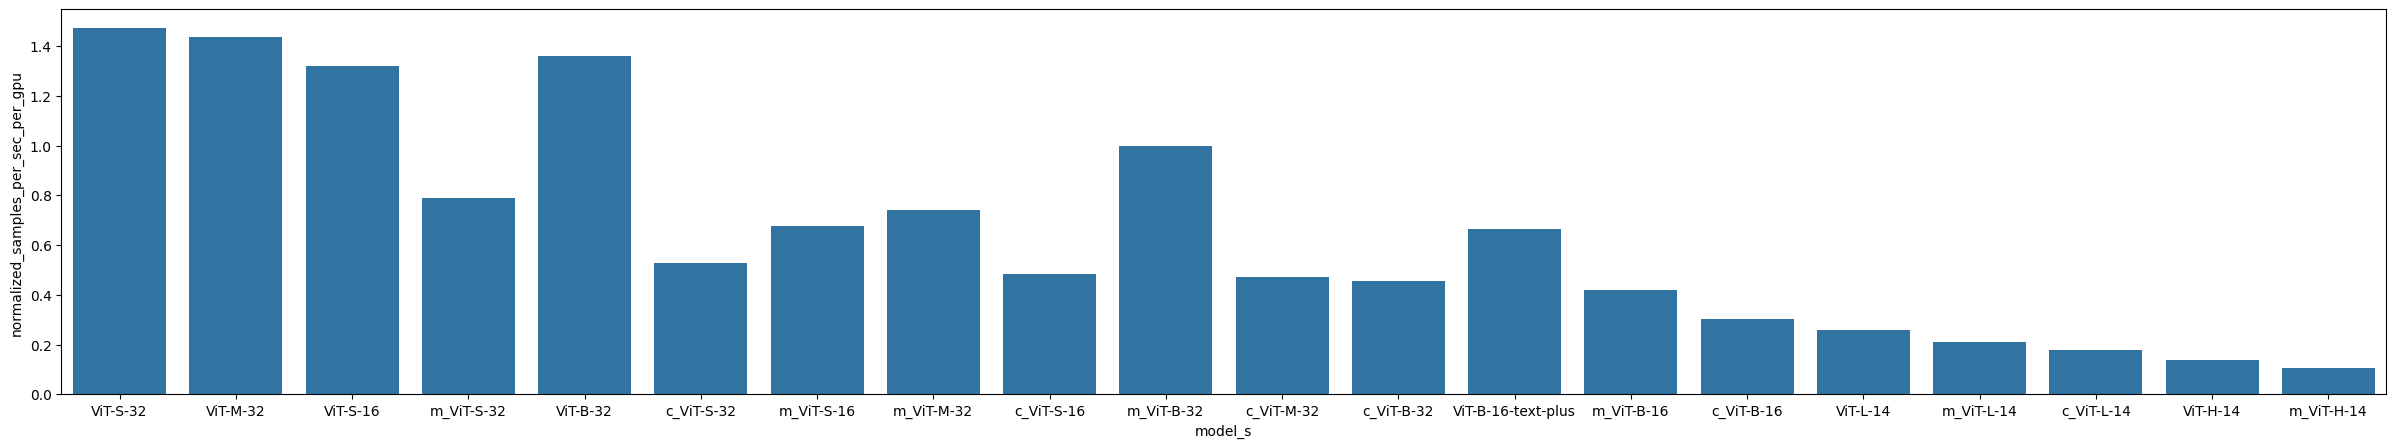

In [78]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))
archs = d.model_s.unique()
archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)

d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
sns.barplot(x="model_s", y="normalized_samples_per_sec_per_gpu", data=d, order=archs, estimator=np.max)

In [79]:
d = df.copy()
d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
d.groupby("model_simple_namespace").max("samples_per_sec_per_gpu").samples_per_sec_per_gpu.sort_values()

model_simple_namespace
ViT-H-14_mammut              55.467589
ViT-H-14_cap                 65.918173
ViT-H-14_clip                74.115664
ViT-L-14_coca               107.178987
ViT-L-14_mammut             118.440348
ViT-L-14_cap                135.658584
ViT-L-14_clip               149.465855
ViT-B-16_coca               195.494934
ViT-B-16_mammut             252.852082
ViT-B-16_cap                294.591618
ViT-B-32_coca               313.512217
ViT-M-32_coca               327.108849
ViT-S-16_coca               338.673007
ViT-S-32_coca               380.128967
ViT-B-16-text-plus_clip     436.032583
ViT-S-16_mammut             480.001876
ViT-B-32_mammut             491.509814
ViT-M-32_mammut             520.326020
ViT-S-16_cap                528.224919
ViT-B-32_cap                554.248881
ViT-M-32_cap                586.268684
ViT-S-32_mammut             591.415351
ViT-S-32_cap                645.252519
ViT-S-16_clip               884.322854
ViT-B-32_clip               919.224325
Vi

# DataComp Recap (recaptioned) vs DataComp results

In [80]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
ds, metric = "winoground", "text_acc"

pretrain_datasets = df.pretrain_dataset.unique()
print(pretrain_datasets)

d = df[~df.pretrain_dataset.isna()].copy()
d["name_wo_ds"] = d.name.apply(lambda n:n.replace("datacomp_recap", "").replace("datacomp", ""))


df_recap = d[d.pretrain_dataset.str.contains("recap")]
df_orig = d[~d.pretrain_dataset.str.contains("recap")]


d = df_recap
d = d[d.epoch == d.total_epochs]
d = d[d.downstream_dataset == ds]


do = df_orig
do = do[do.epoch == do.total_epochs]
do = do[do.downstream_dataset == ds]
d = pd.merge(d, do, on="name_wo_ds", suffixes=("_recap", "_orig"))
d[["name_recap", f"{metric}_recap", f"{metric}_orig"]]

['/p/data1/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar']


,name_recap,text_acc_recap,text_acc_orig
0,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1950,0.1775
1,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2325,0.1750
2,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2000,0.1800
3,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2025,0.1675
4,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2050,0.1600
5,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2150,0.1350
6,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2200,0.1750
7,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2150,0.1825
8,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1925,0.1600
9,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2150,0.1875


# Results per checkpoint

In [100]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
107640,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
107616,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
107504,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
107639,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
80389,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [128]:
d = df
d = d[d.downstream_dataset=="imagenet1k"]
d = d[d.epoch==d.total_epochs]
d = d[d.samples_seen_scale_simple=="12.8B"]
d = d[d.model_simple=="ViT-L-14"]
d = d.sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace"]]
d

,acc1,name,namespace
107652,0.803380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
95820,0.802260,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
80402,0.801680,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
71887,0.801520,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
49539,0.800700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
106034,0.800280,datacomp_s12.8B_bs_360960_mammut_ViT-L-14_ep100_lr0.0035_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n320_bs282_sigFalse,mammut
84450,0.799060,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
86774,0.798600,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n176_bs128_sigFalse,mammut
80202,0.796100,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n176_bs128_sigFalse,mammut
86974,0.793400,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut


In [102]:
df[df.downstream_dataset=="sugar_crepe"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
132476,0.910728,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19
132484,0.910250,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
132481,0.905062,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,18
134758,0.903457,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
132494,0.903354,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,17


In [127]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
71552,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,92
71774,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,100
71884,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,99
71997,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,97
8236,0.865854,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19


In [126]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
49262,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
4495,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
4381,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20
49245,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
49160,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,93


In [125]:
df[df.downstream_dataset=="winoground"].sort_values(by="text_acc", ascending=False).head(20)[["text_acc", "name", "namespace", "epoch"]]

,text_acc,name,namespace,epoch
71630,0.3800,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,40
71904,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,70
71747,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,93
71940,0.3650,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,94
71901,0.3600,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,91
49699,0.3575,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,63
71595,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,86
71834,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,82
71702,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,80
71762,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,45


In [112]:
df[df.downstream_dataset=="winoground"].sort_values(by="image_acc", ascending=False).head()[["image_acc", "name", "namespace", "epoch"]]

,image_acc,name,namespace,epoch
9837,0.2475,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
9748,0.2425,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,16
10086,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,6
2076,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,13
22009,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18


# Specific Training Curves

       epoch       acc
30363      1  0.650406
30897      2  0.703252
30946      3  0.642276
30644      4  0.678862
30441      5  0.727642
31002      6  0.719512
30656      7  0.012195
30930      8  0.000000
30933      9  0.000000
31114     10  0.000000
30856     11  0.000000
30360     12  0.000000
30471     13  0.000000
30386     14  0.000000
30509     15  0.000000
31053     16  0.000000
30801     17  0.000000
30820     18  0.000000
30865     19  0.000000
30720     20  0.365854
30593     21  0.784553
31184     22  0.768293
30713     23  0.768293
30928     24  0.780488
30500     25  0.784553
31149     26  0.784553
30626     27  0.788618
30702     28  0.817073
30992     29  0.792683
30799     30  0.788618
30493     31  0.821138
31011     32  0.796748
30988     33  0.780488
30661     34  0.821138
30625     35  0.784553
30523     36  0.768293
30683     37  0.788618
31129     38  0.800813
30576     39  0.800813
31009     40  0.813008
30520     41  0.788618
30950     42  0.792683
30745     4

Text(0.5, 1.0, 'sugar_crepe/swap_obj acc generative_image_caption_selection')

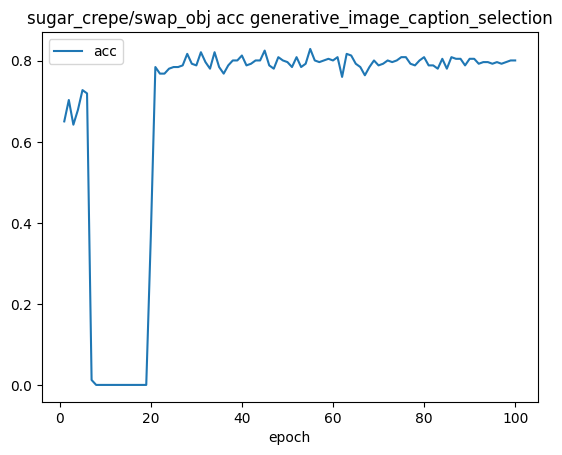

In [132]:
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"

#ds, metric, task = "winoground", "image_acc", "generative_image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
#ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"

d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
print(d[["epoch", metric]])
#print(d[["epoch", metric]])
d.plot(x="epoch", y=metric)
#d[["epoch", metric]]
plt.title(f"{ds} {metric} {task}")

Text(0.5, 1.0, 'winoground generative_image_caption_selection text_acc')

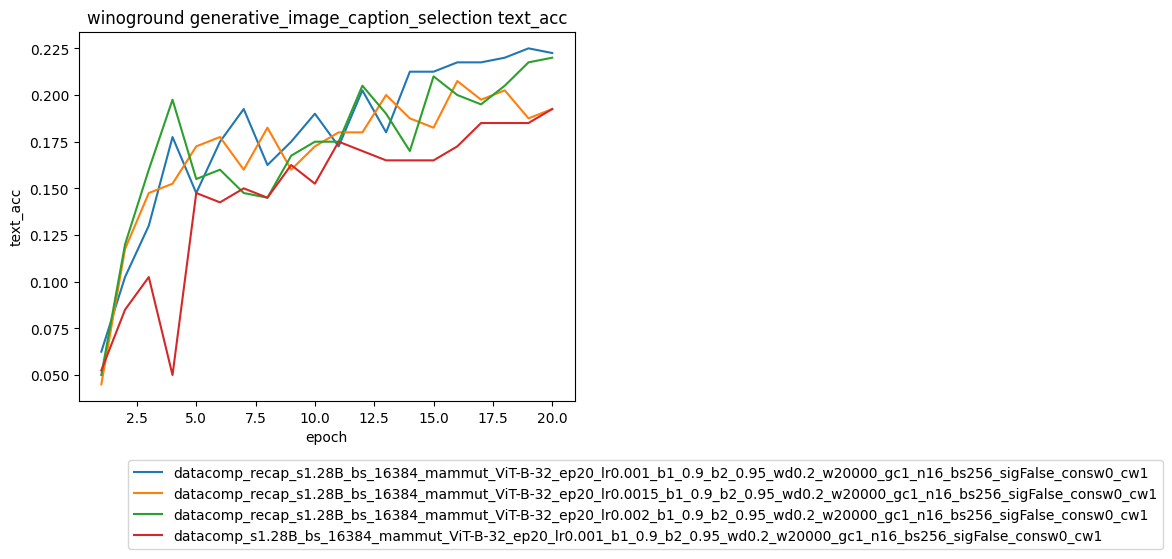

In [124]:
ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
#ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"


#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
names = [
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
]

d = df

d = d[d.name.isin(names)]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="name", data=d)
#d[["epoch", metric]]
plt.legend(loc=(.1,-.4))
plt.title(f"{ds} {task} {metric}")

Text(0.5, 1.0, 'winoground')

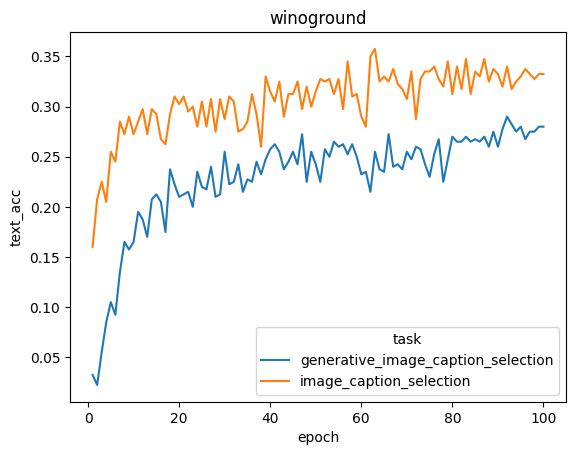

In [117]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "text_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

Text(0.5, 1.0, 'winoground')

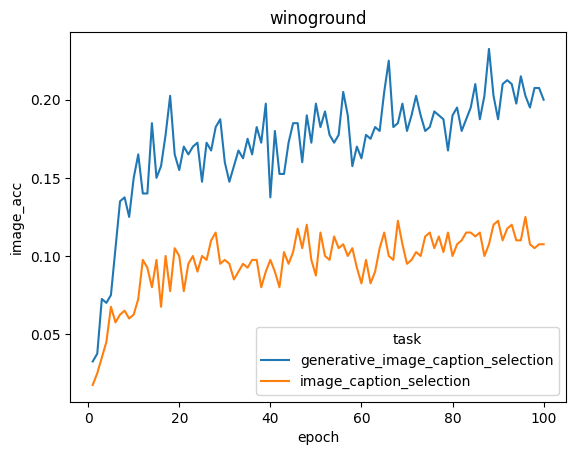

In [52]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

# Full results table

In [53]:
print(df.samples_seen_scale_simple.unique())

['1.28M' '1.28B' '12.8M' '128M' '12.8B' '3B' '64M' '3M' '300M' '6.4M'
 '30M']


In [134]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
ds, metric = "winoground", "text_acc"

d = df
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]


d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
d = d.loc[index]

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,64M,128M,300M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,
ViT-S-32_cap,0.0550,NaN,NaN,0.0900,NaN,NaN,0.1300,NaN,0.1650,NaN,NaN
ViT-S-32_clip,0.2300,0.2150,NaN,0.2425,0.2175,NaN,0.2525,0.2600,0.2675,NaN,NaN
ViT-S-32_coca,0.1900,NaN,NaN,0.2050,0.2100,NaN,0.2350,0.2775,NaN,NaN,NaN
ViT-S-32_mammut,0.1875,0.2350,0.2125,0.1950,0.2275,0.2475,0.2450,0.2925,0.2525,NaN,NaN
ViT-M-32_cap,0.0550,NaN,NaN,0.0900,NaN,NaN,0.1325,NaN,0.2025,NaN,NaN
ViT-M-32_clip,0.2100,0.2250,NaN,0.1925,0.2275,NaN,0.2600,0.2550,0.3150,0.2525,NaN
ViT-M-32_coca,NaN,0.1750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViT-M-32_mammut,0.1950,0.2250,0.2100,0.2175,0.2400,0.2575,0.2350,0.3250,0.2975,NaN,NaN
ViT-S-16_cap,0.0650,NaN,NaN,0.0975,NaN,NaN,0.1400,NaN,0.1875,NaN,NaN


array(['cosine', 'const', 'const-cooldown'], dtype=object)

# Const-LR results

In [55]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"


d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]


d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.lr_scheduler.isin(["cosine", "const-cooldown"])]
d = d[d.namespace == "clip"]
#d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace_scheduler")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace_scheduler"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-2])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,12.8M,30M,128M,300M,1.28B,3B,12.8B
model_simple_namespace_scheduler,,,,,,,,,
ViT-S-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.07572,NaN,0.51138,0.55742,0.59442
ViT-S-32_clip_cosine,0.01304,0.03032,0.10208,0.18664,0.35402,0.43956,0.53118,0.55864,NaN
ViT-M-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.08978,NaN,0.55902,0.60376,0.63916
ViT-M-32_clip_cosine,0.01396,0.03240,0.10504,0.20074,0.38302,0.47810,0.57304,0.60788,NaN
ViT-S-16_clip_const-cooldown,NaN,NaN,NaN,NaN,0.09390,NaN,0.58170,0.62314,0.66210
ViT-S-16_clip_cosine,0.02000,0.04404,0.13388,0.23700,0.42338,0.50486,0.59574,0.62844,NaN
ViT-B-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.10768,NaN,0.60270,0.64746,0.68510
ViT-B-32_clip_cosine,0.01352,0.03194,0.11174,0.21622,0.40396,0.50280,0.60758,0.65288,NaN
ViT-B-16-text-plus_clip_cosine,0.01836,0.03538,0.14776,0.26202,0.46748,0.57774,0.66786,0.71332,NaN


In [13]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"


d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]


d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.lr_scheduler == "const-cooldown"]
d = d[d.model == "ViT-B-32"]
d = d.sort_values(by=metric, ascending=False)
d["train_num_samples"] = d.apply(lambda r:r["total_samples_seen"] / r["total_epochs"], axis=1)    
d[["name", "acc1", "samples_seen_scale_simple", "total_samples_seen", "global_batch_size", "warmup", "train_num_samples"]]

,name,acc1,samples_seen_scale_simple,total_samples_seen,global_batch_size,warmup,train_num_samples
128114,cooldown_s12.8B,0.68510,12.8B,12800000000,90624,4000,12800000.0
130784,cooldown_s12.8B,0.67832,12.8B,12800000000,90624,4000,12800000.0
128600,cooldown_s3B,0.64746,3B,2995200000,90624,4000,12800000.0
131270,cooldown_s3B,0.64212,3B,2995200000,90624,4000,12800000.0
131144,cooldown_s1.28B,0.60270,1.28B,1280000000,90624,4000,12800000.0
128474,cooldown_s1.28B,0.59730,1.28B,1280000000,90624,4000,12800000.0
131188,cooldown_s128M,0.10768,128M,128000000,90624,4000,12800000.0
128518,cooldown_s128M,0.07218,128M,128000000,90624,4000,12800000.0


# Comparison between Log-likehood and Similarity based evaluation

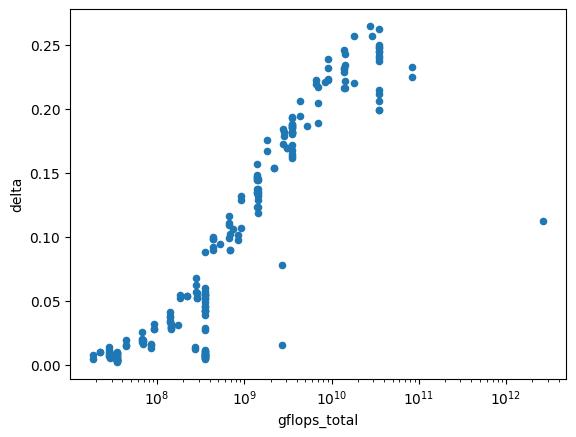

In [14]:
ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "image_caption_selection"
#ds, metric, task = "winoground", "image_acc", "image_caption_selection"

d = df.copy()
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]


gtask = "generative_" + task
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
di = d[d.task==task]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = d.drop_duplicates(subset=["name_wo_task", "task"], keep="first")    
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
d["delta"] = (d[task] - d[gtask]).abs()
d = pd.merge(d, di, left_on='name_wo_task', right_on="name")
d = d.sort_values(by=task, ascending=False)#.head()
#print(d[[gtask, task, "delta", "gflops_total"]].head())
d.plot(x="gflops_total", y="delta", kind="scatter")
plt.xscale('log',base=10)

# Scaling law figures

In [59]:
def monotonically_decreasing(x):
    m = []
    minval = float("inf")
    for xi in x:
        if xi < minval:
            m.append(True)
            minval = xi
        else:
            m.append(False)
    return np.array(m)

def monotonically_increasing(x):
    m = []
    maxval = float("-inf")
    for xi in x:
        if xi > maxval:
            m.append(True)
            maxval = xi
        else:
            m.append(False)
    return np.array(m)

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


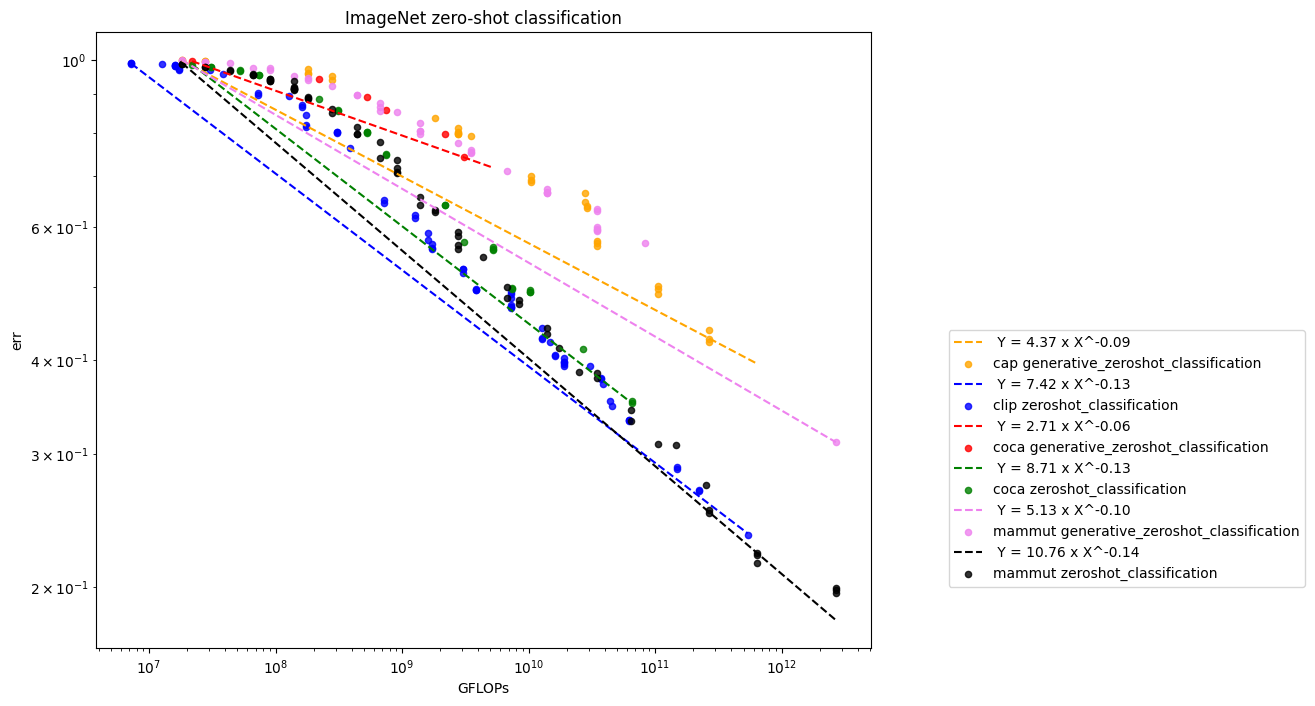

In [61]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"

D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = 1-(R[metric]).values


    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #print(np.unique(X))
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]
    m = monotonically_decreasing(Y)
    #m = X>0
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)

    #plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
plt.legend(loc=(1.1,.1))

#plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

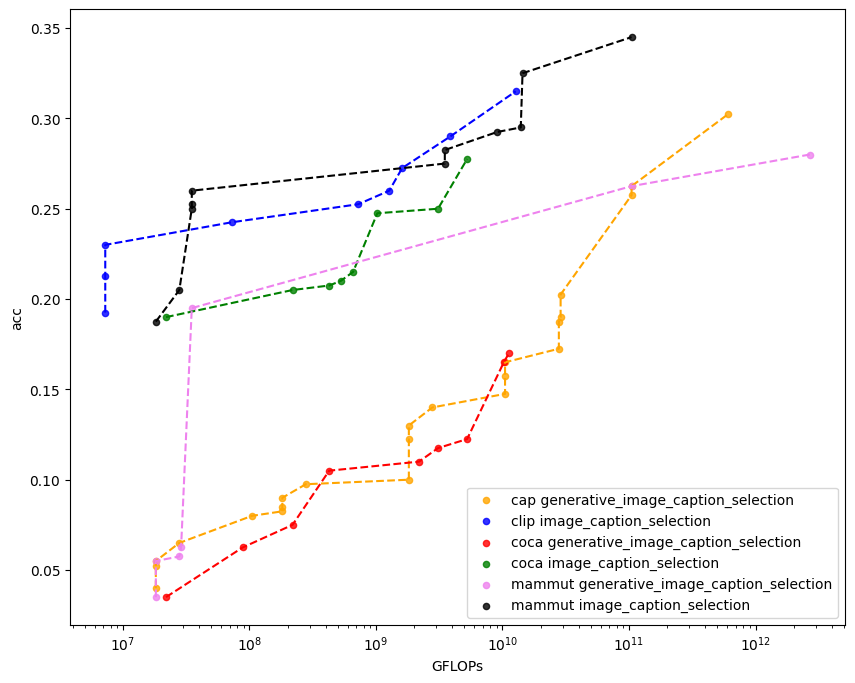

In [66]:
#ds, metric = "imagenet1k", "acc1"
ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "sugar_crepe", "acc"


D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    #Y = 1-(R[metric]).values
    Y = (R[metric]).values

    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    #coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]
    m = monotonically_increasing(Y)
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)

    plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
#plt.yscale("log")

plt.xlabel("GFLOPs")

#plt.ylabel("err")  
plt.ylabel("acc")
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


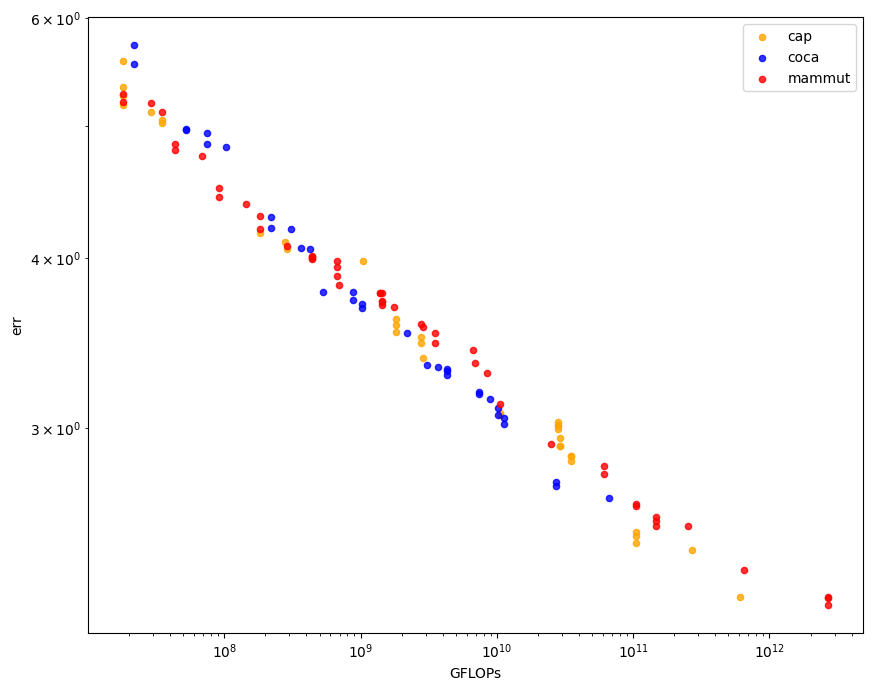

In [68]:
metric = "caption_loss"
D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = monotonically_decreasing(Y)
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


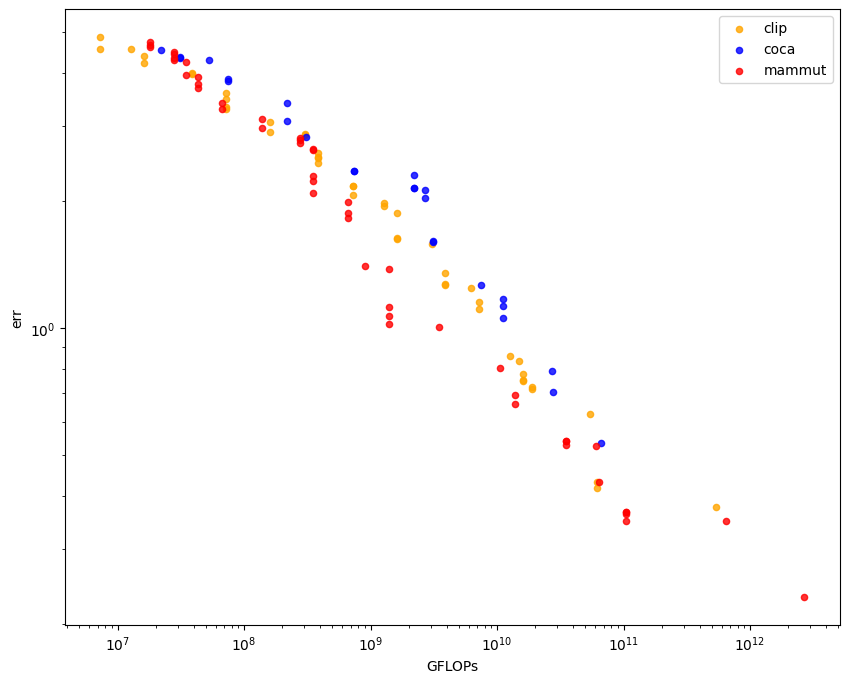

In [69]:
metric = "contrastive_loss"
D = df
D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    if name == "cap":
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = monotonically_decreasing(Y)
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()